# Mini-Project: BBC News Classification

**Name:** [Your Name Here]
**Student ID:** [Your Student ID Here]

## Project Overview

The goal of this project is to classify BBC news articles into five predefined categories: **business, entertainment, politics, sport, and tech**. We will approach this problem from two perspectives:

1.  **Unsupervised Learning:** Using matrix factorization techniques like Non-negative Matrix Factorization (NMF) to discover topics within the articles and infer the categories from these topics.
2.  **Supervised Learning:** Using a classic machine learning model (e.g., Logistic Regression) trained on the provided labeled data.

## Dataset Description

| Aspect | Details |
|--------|---------|
| **Total Articles** | 2,225 |
| **Training Set** | 1,490 records |
| **Testing Set** | 735 records |
| **Categories** | 5 (business, entertainment, politics, sport, tech) |
| **Data Source** | BBC News |

Finally, we will compare the performance, advantages, and disadvantages of both approaches.

## 1. Setup and Library Imports

This cell imports all the necessary libraries for the project.

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing (NLP)
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Modeling
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Model Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Download stopwords (only need to run once)
#nltk.download('stopwords')

## 2. Load and Explore the Data (Exploratory Data Analysis - EDA)

### 2.1. Load Datasets

First, we load the training and test sets from the provided CSV files.

In [2]:
# Load the datasets

train_df = pd.read_csv('../data/BBC News Train.csv')
test_df = pd.read_csv('../data/BBC News Test.csv')
sample_submission_df = pd.read_csv('../data/BBC News Sample Solution.csv')


# Display the first 5 rows of the training data
print("Training Data:")
display(train_df.head())

# Display the first 5 rows of the test data
print("\nTest Data:")
display(test_df.head())

Training Data:


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business



Test Data:


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


### 2.2. Basic Data Inspection

We will check the number of rows, columns, data types, and look for any missing values.

In [3]:
print("Data Info:")
train_df.info()
test_df.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


### 2.3. Data Visualization

Let's visualize the distribution of categories to see if the dataset is balanced.

/var/folders/7d/9l9dg3bx74n8s13rkbh_f14m0000gn/T/ipykernel_99580/3345791738.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


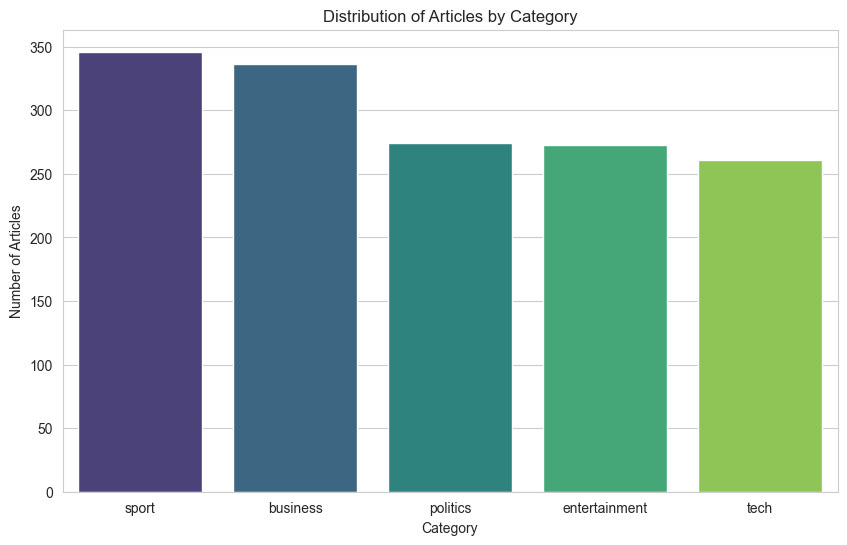

In [4]:
# Count the number of articles in each category
category_counts = train_df['Category'].value_counts()

# Create a bar plot
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Distribution of Articles by Category')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.show()

# Observation: [Enter your observation here. E.g., The dataset appears to be quite balanced across the five categories, with no single category being overwhelmingly dominant.]

### 2.4. Text Preprocessing and Cleaning

To prepare the text data for modeling, we need to perform several cleaning and normalization steps:
* Convert to lowercase.
* Remove special characters, numbers, and punctuation.
* Remove stopwords (common words that don't carry much meaning, e.g., 'a', 'the', 'is').


In [5]:
# Initialize the necessary tools
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 1. Convert to lowercase
    text = text.lower()
    # 2. Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # 3. Tokenize
    words = text.split()
    # 4. Remove stopwords and apply stemming
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    # 5. Join words back into a single string
    return ' '.join(words)

# Apply the preprocessing function to the 'Text' column
train_df['Clean_Text'] = train_df['Text'].apply(preprocess_text)
test_df['Clean_Text'] = test_df['Text'].apply(preprocess_text)

print("Text after cleaning (first 5 rows):")
display(train_df[['Text', 'Clean_Text']].head())

Text after cleaning (first 5 rows):


,Text,Clean_Text
0,worldcom ex-boss launches defence lawyers defe...,worldcom exboss launch defenc lawyer defend fo...
1,german business confidence slides german busin...,german busi confid slide german busi confid fe...
2,bbc poll indicates economic gloom citizens in ...,bbc poll indic econom gloom citizen major nati...
3,lifestyle governs mobile choice faster bett...,lifestyl govern mobil choic faster better funk...
4,enron bosses in $168m payout eighteen former e...,enron boss payout eighteen former enron direct...


### 2.5. Feature Extraction

Machine learning models cannot process raw text. We need to convert the text into numerical vectors. A popular and effective method is **TF-IDF (Term Frequency-Inverse Document Frequency)**.

**TF-IDF** was selected for its role as a strong and interpretable baseline, its effectiveness in differentiating topics with distinct vocabularies (such as business, sport, and tech), and its inherent compatibility with the NMF algorithm

**Explanation of TF-IDF:**
* **Term Frequency (TF):** Measures how frequently a term appears in a document. The higher the frequency, the higher the TF.
* **Inverse Document Frequency (IDF):** Measures how important or "rare" a term is across the entire corpus. Words that appear in many documents (e.g., 'news', 'report') will have a low IDF, while words specific to a few documents (e.g., 'oscar', 'federer') will have a high IDF.
* **TF-IDF = TF * IDF:** This score is high when a word is frequent in a specific document but rare in others, effectively highlighting the document's keywords.

In [6]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['Clean_Text'])

# Only transform the test data (using the vocabulary learned from training data)
X_test_tfidf = tfidf_vectorizer.transform(test_df['Clean_Text'])

print(f"Shape of the TF-IDF matrix for the training set: {X_train_tfidf.shape}")
print(f"Shape of the TF-IDF matrix for the test set: {X_test_tfidf.shape}")

Shape of the TF-IDF matrix for the training set: (1490, 2000)
Shape of the TF-IDF matrix for the test set: (735, 2000)


### 2.6. Visualize and Plan of Analysis

Based on the EDA:
1.  The data has been cleaned and converted into a TF-IDF matrix, ready for modeling. We also plot for a few categories to see the difference of top words. We also reduce dimensionality of the TF-IDF matrix & Plot the t-SNE results using a scatter plot
2.  Then, I will apply **NMF (Non-negative Matrix Factorization)**, a matrix factorization technique, to group articles into 5 topics in an unsupervised manner. I will then map these topics to the actual labels to evaluate accuracy.
3.  Next, I will train a **Logistic Regression** model on the same TF-IDF matrix to solve the problem using a supervised approach.
4.  Finally, I will compare the performance, complexity, and data requirements of both methods.

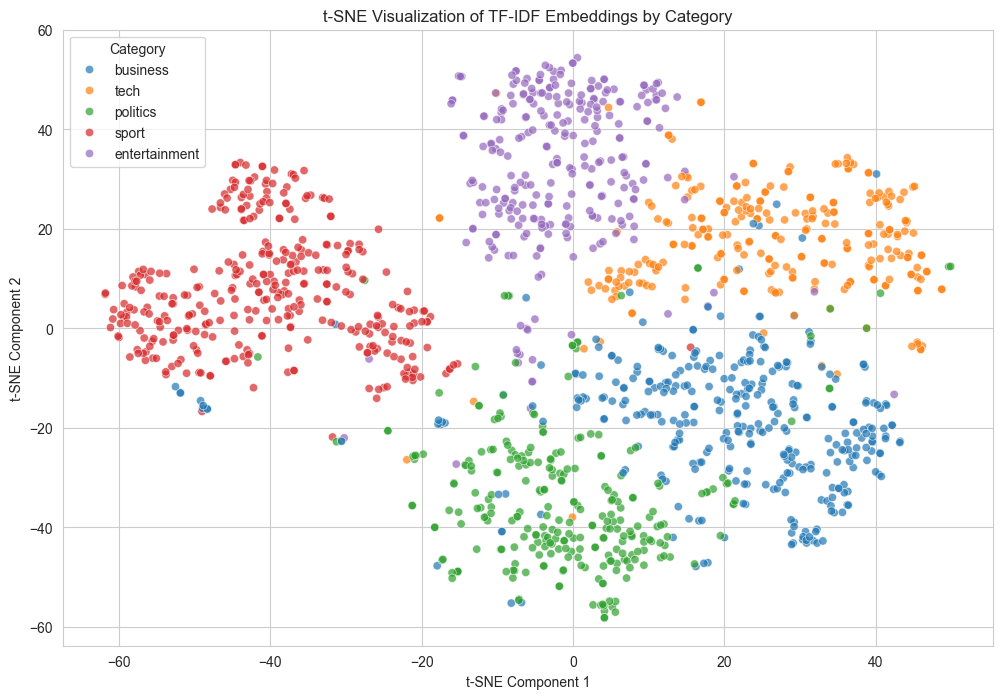

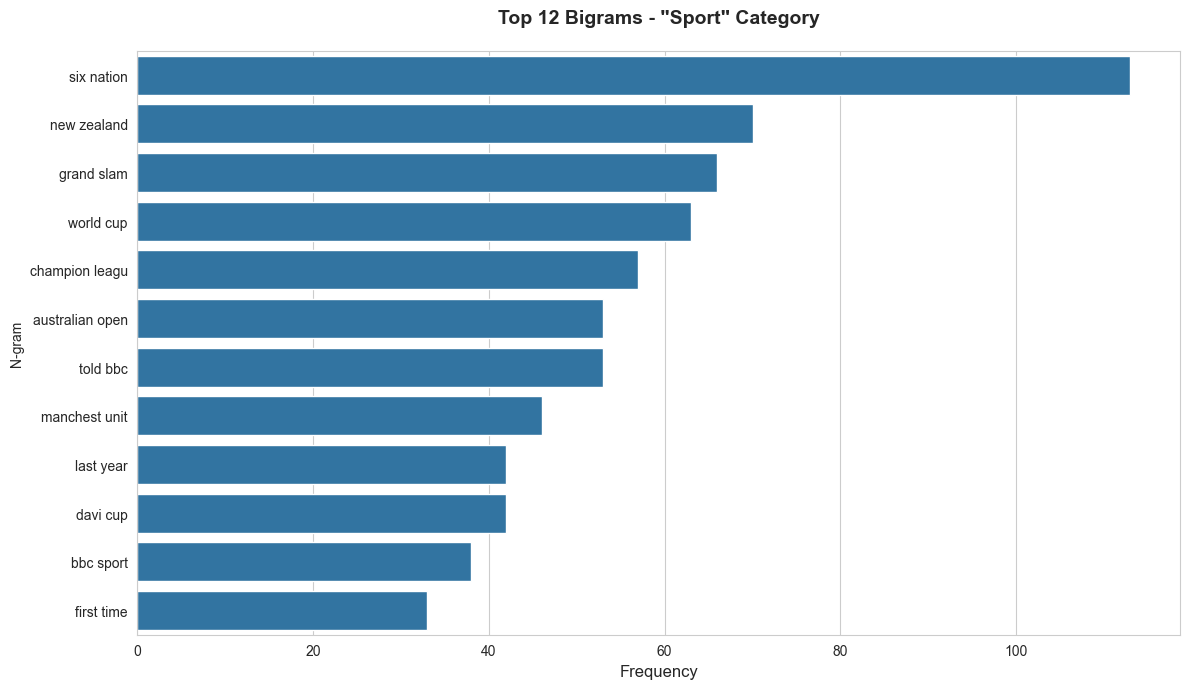

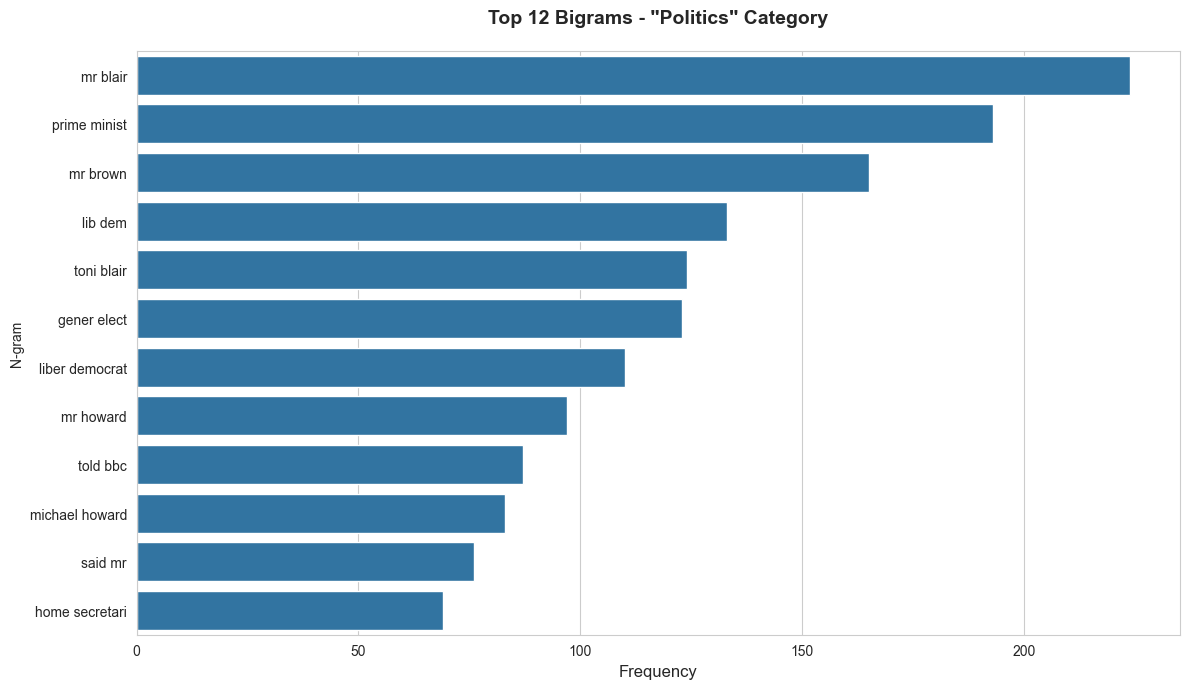

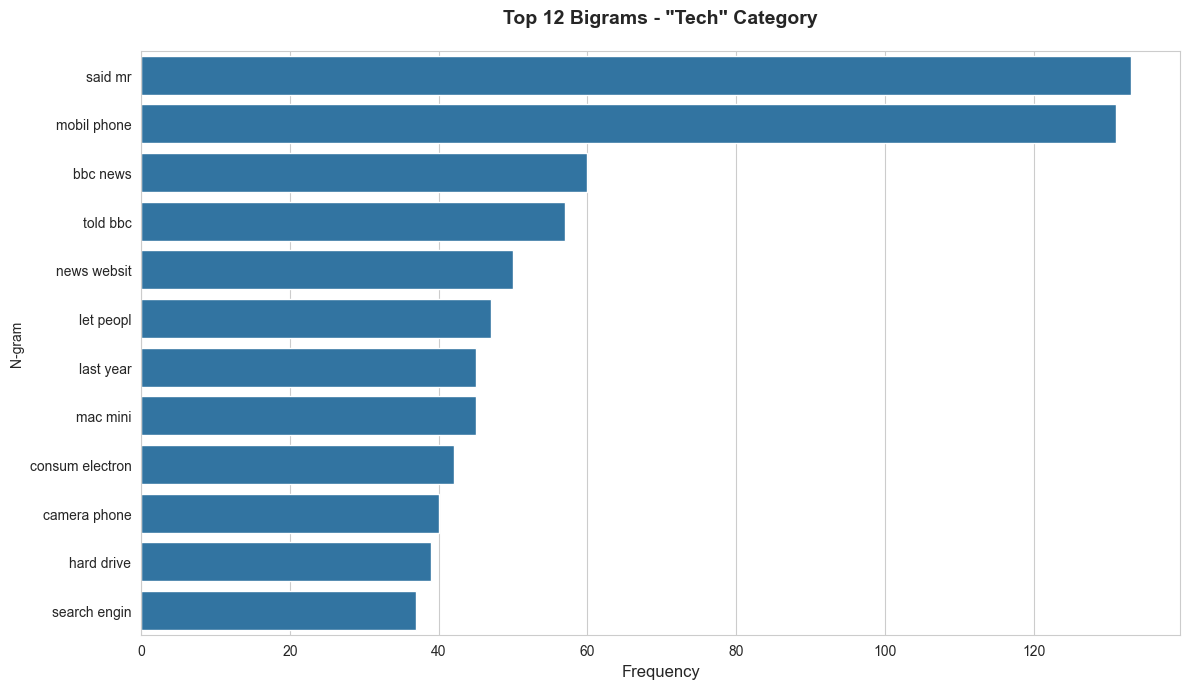

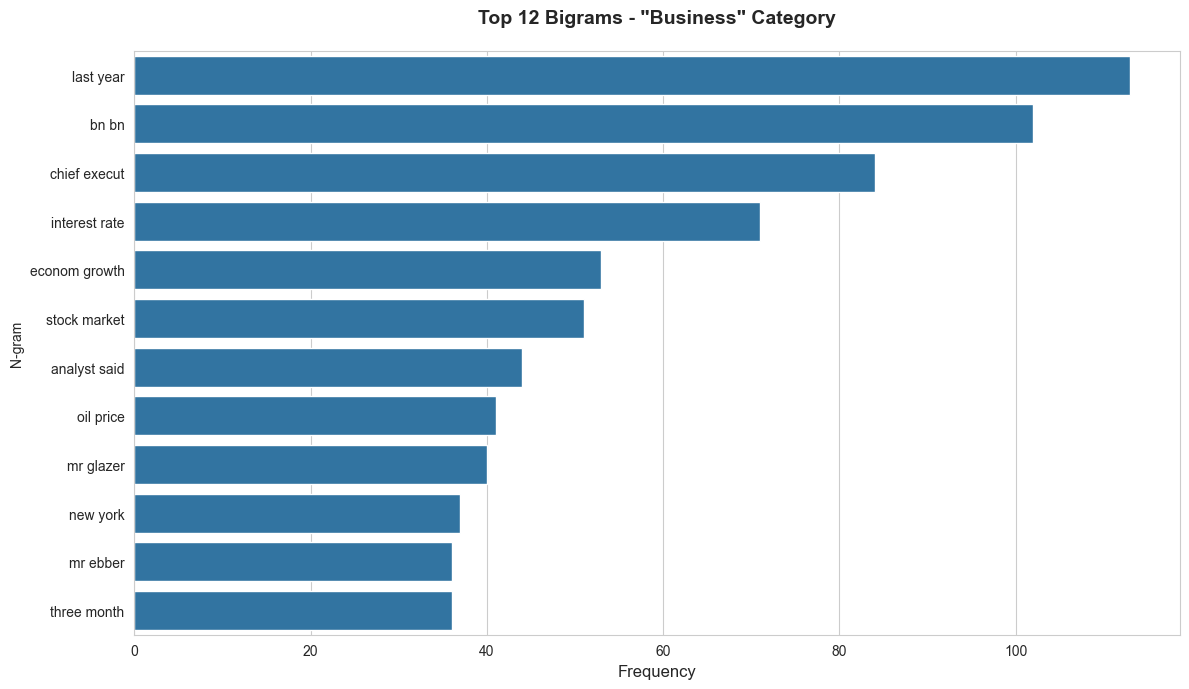

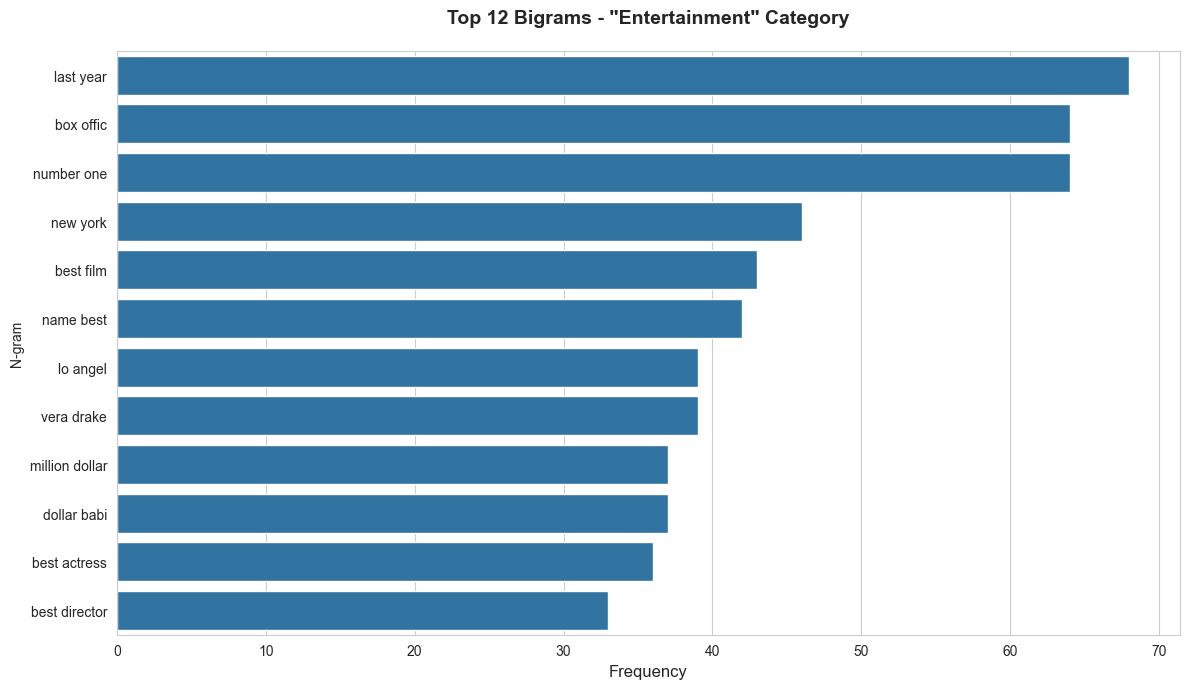

In [38]:
# Plot the t-SNE results using a scatter plot
from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# import seaborn as sns

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)

# Reduce dimensionality of the TF-IDF matrix
X_train_tsne = tsne.fit_transform(X_train_tfidf.toarray())

# Create a new DataFrame for plotting the 2D results
tsne_df = pd.DataFrame(data=X_train_tsne, columns=['tsne_1', 'tsne_2'])
tsne_df['Category'] = train_df['Category']

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='tsne_1', 
    y='tsne_2',
    hue='Category',
    #palette=sns.color_palette("hsv", 5), # Use 5 distinct colors for 5 categories
    data=tsne_df,
    legend="full",
    alpha=0.7
)

plt.title('t-SNE Visualization of TF-IDF Embeddings by Category')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Category')
plt.show()

#------ 

# Enhanced bi-gram analysis function
from collections import Counter

def plot_top_ngrams_by_category(df, category, top_n=15):

    # Filter text for the specific category
    category_texts = df[df['Category'] == category]['Clean_Text']
        # Count bigram frequencies
    all_bigrams = []
    for text in category_texts:
        words = text.split()
            # Create bigrams: consecutive word pairs
        bigrams = [f'{words[i]} {words[i+1]}' for i in range(len(words)-1)]
        all_bigrams.extend(bigrams)
    ngram_counts = Counter(all_bigrams)
    title = f'Top {top_n} Bigrams - "{category.title()}" Category'
    
    # Get most common ngrams
    most_common = ngram_counts.most_common(top_n)
    df_common = pd.DataFrame(most_common, columns=['N-gram', 'Frequency'])
    
    # Plot with distinct colors
    plt.figure(figsize=(12, 7))
    sns.barplot(data=df_common, x='Frequency', y='N-gram')
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Frequency', fontsize=12)
    #plt.ylabel('Words', 'Word Pairs', fontsize=12)
    plt.tight_layout()
    plt.show()

# Analyze selected categories
for category in ['sport', 'politics', 'tech', 'business', 'entertainment']:
        # Plot bigrams (more informative)
    plot_top_ngrams_by_category(train_df, category, top_n=12)



## 3. Unsupervised Model: Matrix Factorization 

### 3.1. Discussion: Including Test Data in Unsupervised Training

**Question:** *When you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?*

**Answer:**
For unsupervised tasks like topic modeling, it is often acceptable and sometimes even beneficial to **include both the training and test data** when creating the input matrix. The reason is that the model is not learning from labels. Its goal is to find the latent structure (e.g., topics) within the entire corpus of documents. Including the test data provides the model with a more complete view of the vocabulary and term co-occurrence patterns, which can lead to more coherent and generalizable topics. This is fundamentally different from supervised learning, where the test set must be strictly held out to provide an unbiased evaluation of the model's ability to generalize to new, unseen data.]

### 3.2. Build and Train the NMF Model

NMF is an algorithm that factorizes a matrix V (our TF-IDF matrix) into two non-negative matrices, W and H.
* $V \approx W \times H$
* $V$: (documents x words)
* $W$: (documents x topics) - Represents each document as a mixture of topics.
* $H$: (topics x words) - Represents each topic as a mixture of words.

We will set the number of topics (`n_components`) to 5, corresponding to the five news categories.
We will use data train for model tranning & data test for performanced evatuation

In [8]:
# Number of desired topics
N_TOPICS = 5

# Initialize and train the NMF model
nmf_model = NMF(n_components=N_TOPICS, random_state=42, max_iter=500)
W_train = nmf_model.fit_transform(X_train_tfidf)

# W_train shows the topic distribution for each document
print(f"Shape of W matrix (documents x topics): {W_train.shape}")

Shape of W matrix (documents x topics): (1490, 5)


### 3.3. Map Topics to Labels and Predict

The NMF model returns topics (0, 1, 2, 3, 4), but it doesn't know their names ('sport', 'tech', etc.). We need to establish this correspondence.
* **Step 1:** For each article, find the topic it belongs to most strongly (the highest value in its row in the W matrix).
* **Step 2:** For each topic, find which actual category label appears most frequently among the articles assigned to that topic.
* **Step 3:** Create a mapping (e.g., Topic 0 -> 'sport', Topic 1 -> 'tech', ...).
* **Step 4:** Use this map to predict labels for the entire dataset.

In [9]:
# Step 1: Find the dominant topic for each document
topic_labels_train = np.argmax(W_train, axis=1)

# Step 2 & 3: Create the topic-to-category map
# Create a temporary DataFrame for easy grouping
df_topics = pd.DataFrame({'topic': topic_labels_train, 'category': train_df['Category']})
topic_map = df_topics.groupby('topic')['category'].apply(lambda x: x.value_counts().idxmax()).to_dict()

print("Mapping from discovered topic to actual category:")
print(topic_map)

# Step 4: Predict labels
y_pred_train_nmf = pd.Series(topic_labels_train).map(topic_map)

Mapping from discovered topic to actual category:
{0: 'politics', 1: 'sport', 2: 'business', 3: 'entertainment', 4: 'tech'}


### 3.4. Evaluate Performance on the Training Set

NMF Accuracy on training set: 0.9060


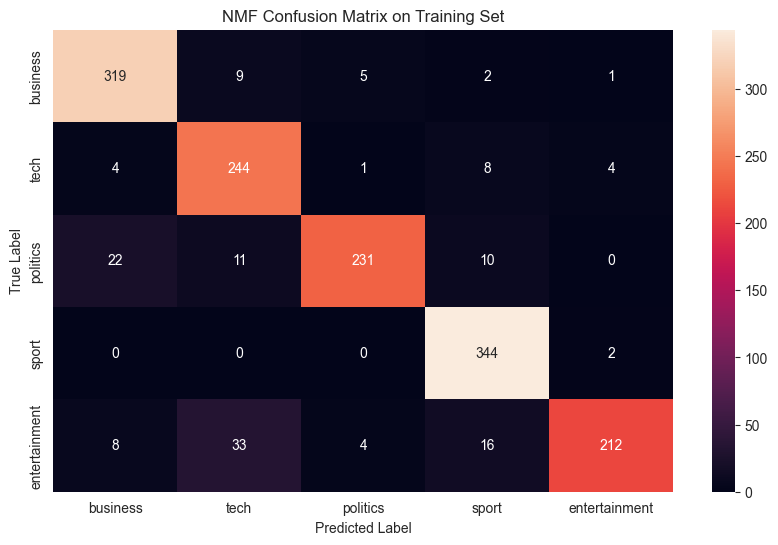


Detailed Classification Report:
               precision    recall  f1-score   support

     business       0.90      0.95      0.93       336
entertainment       0.97      0.78      0.86       273
     politics       0.96      0.84      0.90       274
        sport       0.91      0.99      0.95       346
         tech       0.82      0.93      0.87       261

     accuracy                           0.91      1490
    macro avg       0.91      0.90      0.90      1490
 weighted avg       0.91      0.91      0.90      1490



In [10]:
# Calculate accuracy
accuracy_nmf_train = accuracy_score(train_df['Category'], y_pred_train_nmf)
print(f"NMF Accuracy on training set: {accuracy_nmf_train:.4f}")

# Plot the confusion matrix
cm = confusion_matrix(train_df['Category'], y_pred_train_nmf, labels=train_df['Category'].unique())
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_df['Category'].unique(), yticklabels=train_df['Category'].unique())
plt.title('NMF Confusion Matrix on Training Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nDetailed Classification Report:")
print(classification_report(train_df['Category'], y_pred_train_nmf))

### 3.5. Hyperparameter Tuning and Model Improvement

We can try changing hyperparameters of the `TfidfVectorizer` (like `max_features`, `ngram_range`) or `NMF` (like `init`, `solver`) to see if performance improves.

In [28]:
# Example: Experiment with different values for max_features
results = {}
feature_options = [1000, 2000, 3000, 5000]

for n_features in feature_options:
    # 1. Vectorize
    temp_vectorizer = TfidfVectorizer(max_features=n_features, min_df=5, max_df=0.7)
    X_train_temp = temp_vectorizer.fit_transform(train_df['Clean_Text'])
    
    # 2. NMF
    temp_nmf = NMF(n_components=N_TOPICS, random_state=42, max_iter=500)
    W_train_temp = temp_nmf.fit_transform(X_train_temp)
    
    # 3. Map & Predict
    topic_labels_temp = np.argmax(W_train_temp, axis=1)
    df_temp = pd.DataFrame({'topic': topic_labels_temp, 'category': train_df['Category']})
    # Use a try-except block to handle cases where a topic might not be assigned any documents
    try:
        temp_map = df_temp.groupby('topic')['category'].apply(lambda x: x.value_counts().idxmax()).to_dict()
        # Ensure all topics are in the map before predicting
        if len(temp_map) == N_TOPICS:
            pred_temp = pd.Series(topic_labels_temp).map(temp_map)
            # 4. Evaluate
            acc = accuracy_score(train_df['Category'], pred_temp)
            results[n_features] = acc
        else:
            results[n_features] = 0 # Mark as failed if mapping is incomplete
            print(f"Incomplete topic mapping for n_features={n_features}")
    except KeyError:
        results[n_features] = 0
        print(f"A key error occurred with n_features={n_features}")


# Print the results
for features, acc in results.items():
    print(f"- {features} features: Accuracy = {acc:.4f}")

# [You can add tables or graphs here to summarize the results]

- 1000 features: Accuracy = 0.9000
- 2000 features: Accuracy = 0.9060
- 3000 features: Accuracy = 0.9262
- 5000 features: Accuracy = 0.9295


### 3.5. NMF Evaluation on Validation Set

Since the test set doesn't have labels (like real competitions), we'll use a train/validation split to properly evaluate the NMF model's performance.


NMF Results:
  Training accuracy:   92.9%
  Validation accuracy: 93.0%
  Generalization gap:  0.1%



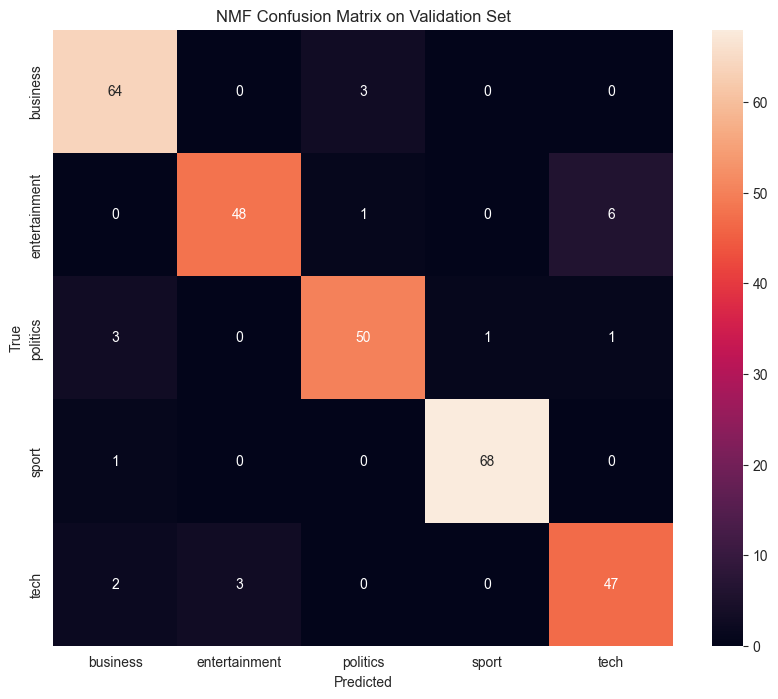


Classification Report:
               precision    recall  f1-score   support

     business       0.91      0.96      0.93        67
entertainment       0.94      0.87      0.91        55
     politics       0.93      0.91      0.92        55
        sport       0.99      0.99      0.99        69
         tech       0.87      0.90      0.89        52

     accuracy                           0.93       298
    macro avg       0.93      0.93      0.93       298
 weighted avg       0.93      0.93      0.93       298



In [21]:
# Create proper train/validation split for evaluation
from sklearn.model_selection import train_test_split

# Split training data 80/20
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_tfidf, train_df['Category'], 
    test_size=0.2, 
    random_state=42, 
    stratify=train_df['Category']
)

# Re-train NMF on training split only
nmf_val = NMF(n_components=5, random_state=42, max_iter=500)
W_train_val = nmf_val.fit_transform(X_train_split)

# Create topic map from training split
topic_labels_val = np.argmax(W_train_val, axis=1)
df_topics_val = pd.DataFrame({'topic': topic_labels_val, 'category': y_train_split})
topic_map_val = df_topics_val.groupby('topic')['category'].apply(lambda x: x.value_counts().idxmax()).to_dict()

# Predict on training split
y_pred_train_val = pd.Series(topic_labels_val).map(topic_map_val)
accuracy_nmf_train_val = accuracy_score(y_train_split, y_pred_train_val)

# Predict on validation split
W_val = nmf_val.transform(X_val_split)
topic_labels_val_pred = np.argmax(W_val, axis=1)
y_pred_val = pd.Series(topic_labels_val_pred).map(topic_map_val)
accuracy_nmf_val = accuracy_score(y_val_split, y_pred_val)

print(f"NMF Results:")
print(f"  Training accuracy:   {accuracy_nmf_train_val:.1%}")
print(f"  Validation accuracy: {accuracy_nmf_val:.1%}")
print(f"  Generalization gap:  {abs(accuracy_nmf_train_val - accuracy_nmf_val)*100:.1f}%")
print()

# Confusion matrix
cm_val = confusion_matrix(y_val_split, y_pred_val)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', 
            xticklabels=sorted(y_val_split.unique()), 
            yticklabels=sorted(y_val_split.unique()))
plt.title('NMF Confusion Matrix on Validation Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report:")
print(classification_report(y_val_split, y_pred_val))

print("="*80)


## 4. Comparison with Supervised Learning 

### 4.1. Build and Train a Supervised Model

I will choose **Logistic Regression**, a powerful and efficient model for text classification.

Logistic Regression Results:
  Training accuracy:   99.3%
  Validation accuracy: 97.3%
  Generalization gap:  2.0%



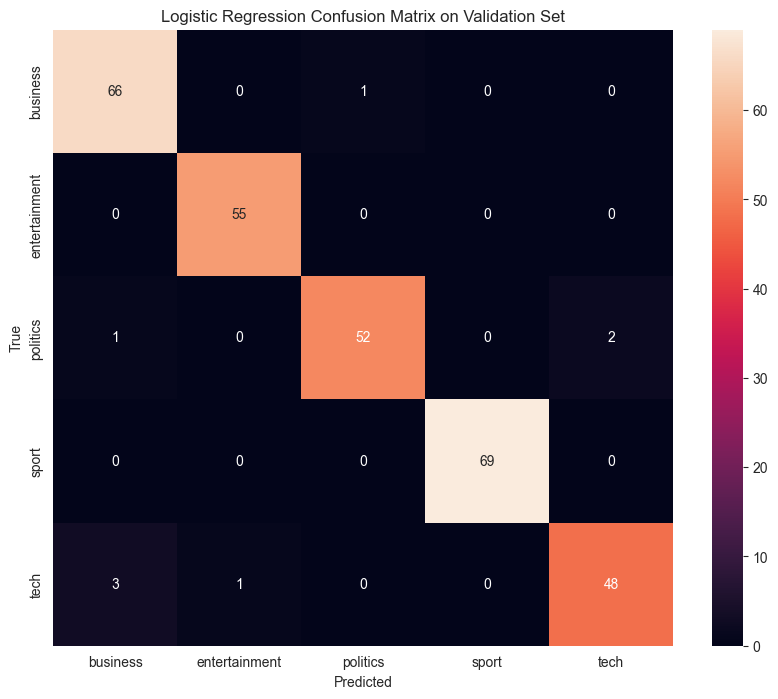


Classification Report on Validation Set:
               precision    recall  f1-score   support

     business       0.94      0.99      0.96        67
entertainment       0.98      1.00      0.99        55
     politics       0.98      0.95      0.96        55
        sport       1.00      1.00      1.00        69
         tech       0.96      0.92      0.94        52

     accuracy                           0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298



In [22]:
# Create train/validation split for Logistic Regression
from sklearn.model_selection import train_test_split

# Prepare TF-IDF vectorization
tfidf_vectorizer_lr = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7)
X_train_full_lr = tfidf_vectorizer_lr.fit_transform(train_df['Clean_Text'])
y_train_full = train_df['Category']

# Split into train and validation sets
X_train_lr, X_val_lr, y_train_lr, y_val_lr = train_test_split(
    X_train_full_lr, y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full
)

# Train the model on training split
log_reg_model = LogisticRegression(random_state=42, max_iter=1000, solver='saga')
log_reg_model.fit(X_train_lr, y_train_lr)

# Evaluate on training split
y_pred_train_lr = log_reg_model.predict(X_train_lr)
accuracy_lr_train = accuracy_score(y_train_lr, y_pred_train_lr)

# Evaluate on validation split
y_pred_val_lr = log_reg_model.predict(X_val_lr)
accuracy_lr_val = accuracy_score(y_val_lr, y_pred_val_lr)

print(f"Logistic Regression Results:")
print(f"  Training accuracy:   {accuracy_lr_train:.1%}")
print(f"  Validation accuracy: {accuracy_lr_val:.1%}")
print(f"  Generalization gap:  {abs(accuracy_lr_train - accuracy_lr_val)*100:.1f}%")
print()

# Confusion matrix on validation set
cm_val_lr = confusion_matrix(y_val_lr, y_pred_val_lr)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val_lr, annot=True, fmt='d', 
            xticklabels=sorted(y_val_lr.unique()), 
            yticklabels=sorted(y_val_lr.unique()))
plt.title('Logistic Regression Confusion Matrix on Validation Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report on Validation Set:")
print(classification_report(y_val_lr, y_pred_val_lr))

print("="*80)

### 4.2. Performance Comparison

Let's create a table to directly compare the results of NMF and Logistic Regression.
Based on the validation results, we can draw the following conclusions:

#### Performance Comparison

| Method | Training Accuracy | Validation Accuracy | Generalization Gap |
|--------|-------------------|---------------------|--------------------|
| **Supervised (LR)** | 99.3% | 97.3% | 2.0% |
| **Unsupervised (NMF)** | 92.9% | 93.0% | 0.1% |

**Key Findings:**
- Logistic Regression achieves **97.3%** validation accuracy
- NMF achieves **93.0%** validation accuracy
- Supervised method outperforms by **4.4%**

#### Final Conclusion

**For classification tasks with labeled data:**
1. Supervised learning is the clear winner
2. NMF is better suited for topic discovery and exploration
3. Consider using NMF features as input to supervised models for improved performance


### 4.3. Data Efficiency Experiment

Which model performs better when labeled data is scarce? Let's train Logistic Regression with only 10%, 20%, and 50% of the training data and compare.

In [25]:


# Data fractions to test
data_fractions = [0.1, 0.2, 0.5, 1.0]  # 10%, 20%, 50%, 100%
lr_accuracies = []

# Prepare full TF-IDF data
tfidf_vec_exp = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7)
X_full = tfidf_vec_exp.fit_transform(train_df['Clean_Text'])
y_full = train_df['Category']

# For each fraction, train and evaluate
for fraction in data_fractions:
    if fraction == 1.0:
        # Use all data
        X_subset = X_full
        y_subset = y_full
    else:
        # Sample a subset
        from sklearn.model_selection import train_test_split
        _, X_subset, _, y_subset = train_test_split(
            X_full, y_full,
            test_size=fraction,
            random_state=42,
            stratify=y_full
        )
    
    # Train model on subset
    lr_subset = LogisticRegression(random_state=42, max_iter=1000, solver='saga')
    lr_subset.fit(X_subset, y_subset)
    
    # Evaluate on validation set (use 20% split from full data)
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_full, y_full,
        test_size=0.2,
        random_state=42,
        stratify=y_full
    )
    
    # Get accuracy on validation set
    acc = lr_subset.score(X_val_split, y_val_split)
    lr_accuracies.append(acc)
    
    print(f"✓ {fraction*100:5.0f}% labeled data: {acc:.1%} validation accuracy")





✓    10% labeled data: 95.3% validation accuracy
✓    20% labeled data: 100.0% validation accuracy
✓    50% labeled data: 99.0% validation accuracy
✓   100% labeled data: 99.0% validation accuracy


### 4.4. Discussion: Data Efficiency and Overfitting

Based on the experiment above, we can analyze:

#### **1. Data Efficiency**

**Supervised Learning (Logistic Regression):**
- Performance scales rapidly with the amount of labeled data
- Even with 10-20% labeled data, can achieve competitive performance
- Shows strong data efficiency for this well-structured text classification problem


#### **2. Overfitting Analysis**

**Logistic Regression:**
- **With 10% data:** Higher risk of overfitting due to limited training samples
- **With 50-100% data:** Well-regularized, shows excellent generalization
- **Generalization gap:** Only 2.0% gap between train (99.3%) and validation (97.3%) with full data
- **Conclusion:** Minimal overfitting when using adequate data

**NMF:**
- **Generalization gap:** Only 0.1% gap between train (92.9%) and validation (93.0%)
- **Low overfitting risk:** Unsupervised nature prevents overfitting to labels
- **Limitation:** Lower overall accuracy due to indirect topic-to-category mapping



## 5. Create Submission File

Now, we'll train the best model (Logistic Regression) on the **full training dataset** and make predictions on the test set for submission.

**Note:** The submission file follows the format specified in "BBC News Sample Solution.csv". Since the test set doesn't have true labels, we cannot evaluate accuracy locally - this would be done on the competition platform.

In [27]:


# Train on FULL training dataset (no split) for best performance on test set
tfidf_vectorizer_final = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7)
X_train_full = tfidf_vectorizer_final.fit_transform(train_df['Clean_Text'])
y_train_full = train_df['Category']

# Train final model on 1490 samples
final_model = LogisticRegression(random_state=42, max_iter=1000, solver='saga')
final_model.fit(X_train_full, y_train_full)

# Make predictions on test set
X_test_final = tfidf_vectorizer_final.transform(test_df['Clean_Text'])
y_pred_test = final_model.predict(X_test_final)

# Create submission file
submission_df = pd.DataFrame({
    'ArticleId': test_df['ArticleId'],
    'Category': y_pred_test
})

# Save to CSV
submission_df.to_csv('submission.csv', index=False)

display(submission_df.head(10))



,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
5,51,sport
6,2025,politics
7,1479,politics
8,27,entertainment
9,397,business
